# `MonotonicSplineEpistasis` model
Simulates some variants and analyzes them under the `globalepistasis.MonotonicSplineEpistasis` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import cProfile
import math
import pstats
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 18  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'loose_bottle': variants_per_lib * 1000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 18 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTA


Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

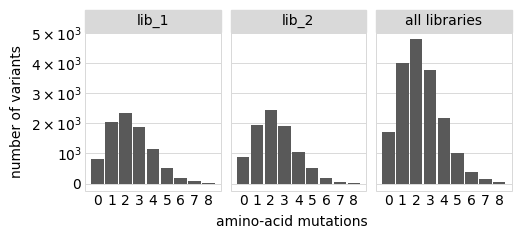

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variant counts
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    )

Plot relationship between simulated and observed phenotypes:

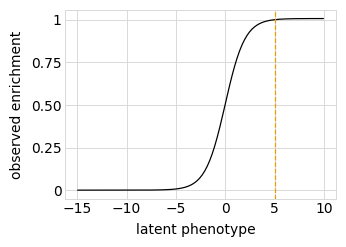

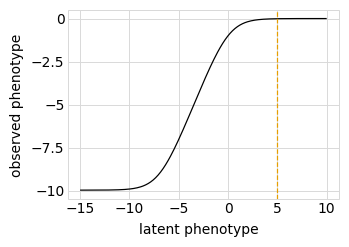

In [10]:
for value in ['enrichment', 'phenotype']:
    p = phenosimulator.plotLatentVsObserved(value)
    _ = p.draw()

Plot latent and observed phenotypes of all single amino-acid mutants:

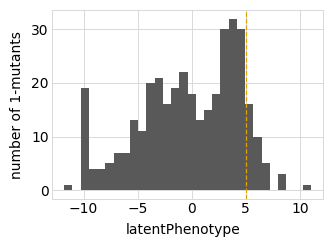

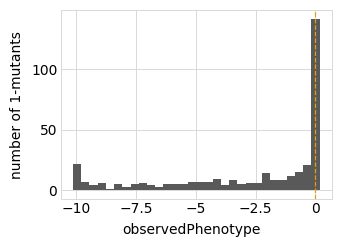

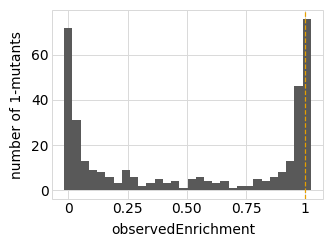

In [11]:
for value in ['latentPhenotype', 'observedPhenotype', 'observedEnrichment']:
    p = phenosimulator.plotMutsHistogram(value)
    _ = p.draw()

Now we simulate the counts according to the observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenosimulator.observedEnrichment,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

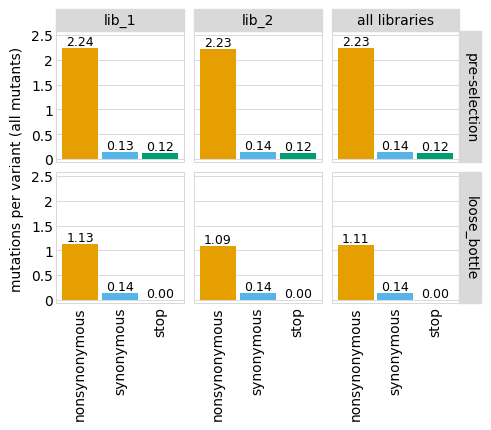

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,20160471,9000000,2.240052
1,lib_1,pre-selection,synonymous,1190230,9000000,0.132248
2,lib_1,pre-selection,stop,1081015,9000000,0.120113
3,lib_1,loose_bottle,nonsynonymous,10150718,9000000,1.127858
4,lib_1,loose_bottle,synonymous,1228868,9000000,0.136541
5,lib_1,loose_bottle,stop,3710,9000000,0.000412
6,lib_2,pre-selection,nonsynonymous,20028816,9000000,2.225424
7,lib_2,pre-selection,synonymous,1275581,9000000,0.141731
8,lib_2,pre-selection,stop,1060811,9000000,0.117868
9,lib_2,loose_bottle,nonsynonymous,9766754,9000000,1.085195


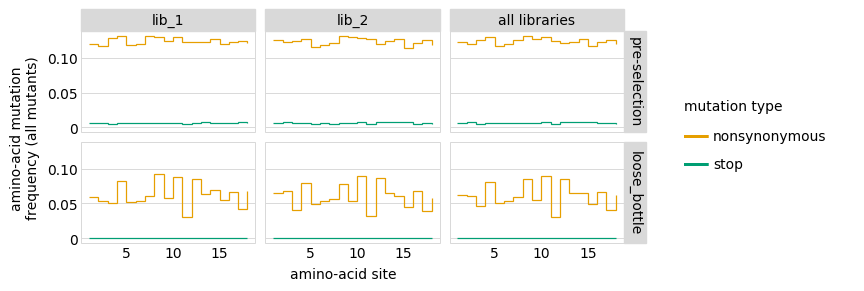

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

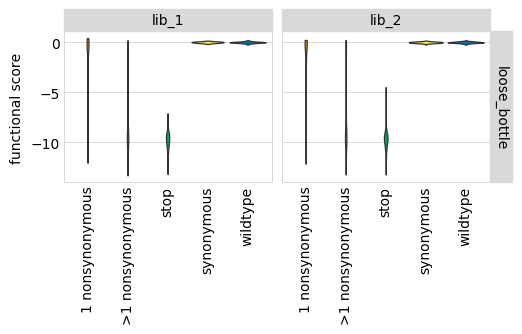

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize model

Make a binary map for the variants:

In [20]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 360


Now initialize the model:

In [21]:
spline_model = dms_variants.globalepistasis.MonotonicSplineEpistasis(binarymap)

Look at some model attributes:

In [22]:
spline_model.nparams

368

In [23]:
spline_model.epistasis_HOC

1.0

In [24]:
round(spline_model.loglik)

-688635.0

In [25]:
spline_model.latent_phenotype_wt

0.0

In [26]:
for key, val in spline_model.epistasis_func_params_dict.items():
    print(f"{key}: {round(val, 2)}")

c_alpha: -13.32
alpha_1: 2.75
alpha_2: 2.75
alpha_3: 2.75
alpha_4: 2.75
alpha_5: 2.75


Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

In [27]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Fit model
Perform initial least squares optimization followed by rescaling latent effects (normally this is actually performed by the `fit` method):

In [28]:
spline_model._fit_latent_leastsquares()
spline_model._prescale_params()

Re-check the gradients:

In [29]:
err = scipy.optimize.check_grad(
            spline_model._loglik_by_allparams,
            spline_model._dloglik_by_allparams,
            spline_model._allparams)
tot = math.sqrt(sum(spline_model._dloglik_by_allparams(spline_model._allparams)**2))
if err / tot > 1e-3:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

Print model parameters after this "partial" fitting:

In [30]:
round(spline_model.loglik)

-49507.0

In [31]:
round(spline_model.epistasis_HOC, 3)

5.193

In [32]:
round(spline_model.latent_phenotype_wt, 3)

0.875

Now fit the model by maximum likelihood, also profiling [as here](https://stackoverflow.com/a/1584468):

In [33]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
profiler = cProfile.Profile()
optres = profiler.runcall(spline_model.fit)
optres = spline_model.fit()
print(f"Fitting took {time.time() - start:.3f} seconds")
print(f"Iterations: {optres.nit}.\n"
      f"Function evaluations: {optres.nfev}\n"
      f"Termination message: {optres.message}")

Fitting took 86.363 seconds
Iterations: 521.
Function evaluations: 584
Termination message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Look at some of the model parameters after optimization:

In [34]:
round(spline_model.loglik)

-2846.0

In [35]:
round(spline_model.epistasis_HOC, 3)

0.005

In [36]:
round(spline_model.latent_phenotype_wt, 3)

0.0

In [37]:
spline_model._mesh.round(1)

array([-4.6, -3.3, -1.9, -0.5])

In [38]:
spline_model.alpha_ms.round(2)

array([0.  , 0.  , 0.  , 9.61, 0.06])

In [39]:
round(spline_model.c_alpha, 2)

-9.7

Plot correlation of actual functional scores with latent and observed phenotypes:


Correlation for latent:
R = 0.826, P = 0

Correlation for observed:
R = 0.991, P = 0


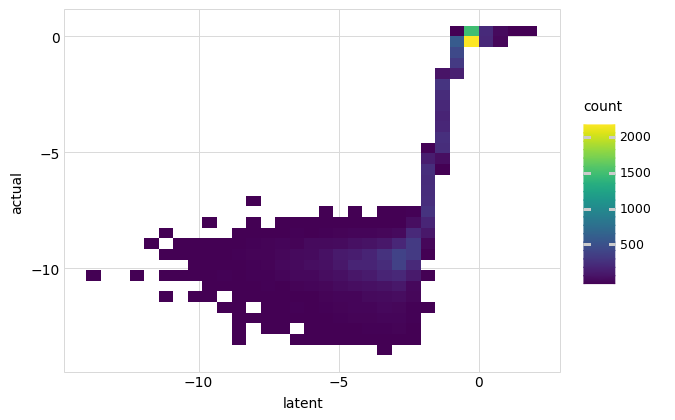

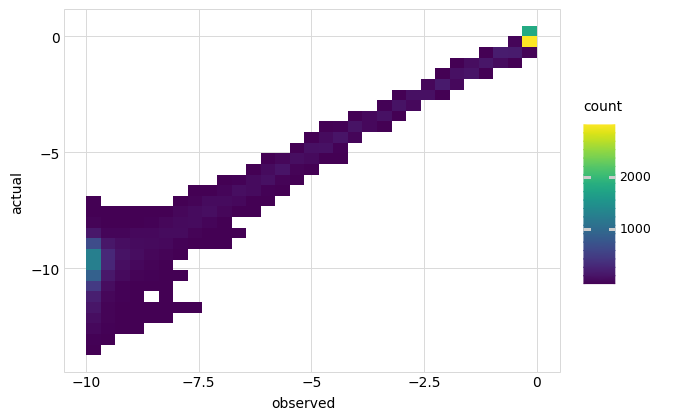

In [40]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'latent': spline_model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'latent'),
                   'observed': spline_model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'observed'),
                   })

for phenotype in ['latent', 'observed']:
    r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        spline_model.phenotypes_frombinary(binarymap.binary_variants, phenotype)
        )
    print(f"\nCorrelation for {phenotype}:\nR = {r:.3f}, P = {p:.2g}")

    _ = (ggplot(df, aes(phenotype, 'actual')) +
         geom_bin2d()
         ).draw()

Plot latent versus observed phenotypes:

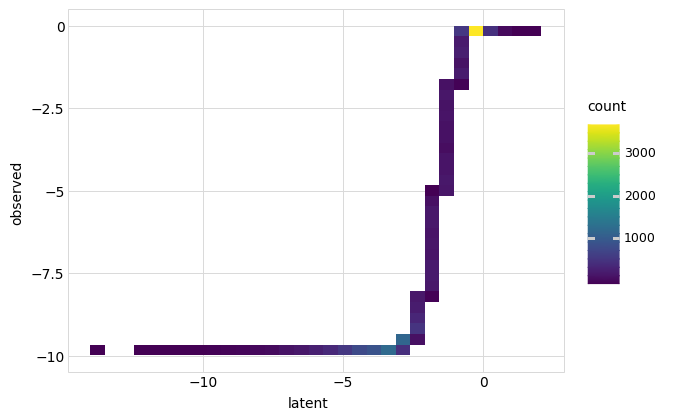

In [41]:
_ = (ggplot(df, aes('latent', 'observed')) +
     geom_bin2d()
     ).draw()

Look at profiling results:

In [42]:
# NBVAL_IGNORE_OUTPUT
with tempfile.NamedTemporaryFile('w') as f:
    profiler.dump_stats(f.name)
    f.flush()
    stats = pstats.Stats(f.name).strip_dirs()
for stat in ['cumtime', 'tottime']:
    print(stats.sort_stats(stat).print_stats(20))

Wed Oct 30 16:41:43 2019    /tmp/tmps_2g1ge8

         16320707 function calls (14724908 primitive calls) in 66.318 seconds

   Ordered by: cumulative time
   List reduced from 342 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   66.318   66.318 globalepistasis.py:670(fit)
        1    0.000    0.000   66.262   66.262 _minimize.py:42(minimize)
        1    0.201    0.201   66.262   66.262 lbfgsb.py:211(_minimize_lbfgsb)
     1715    0.011    0.000   66.054    0.039 lbfgsb.py:284(func_and_grad)
822628/5146    1.429    0.000   52.057    0.010 methodtools.py:31(__call__)
     5146    1.563    0.000   52.003    0.010 ispline.py:247(_calculate_Itotal_or_dItotal)
    34285    3.059    0.000   46.824    0.001 ispline.py:673(_calculate_I_or_dI)
     1715    0.005    0.000   38.437    0.022 optimize.py:324(function_wrapper)
     1715    0.005    0.000   38.432    0.022 globalepistasis.py:724(_loglik_by_allparams

## Examine single mutants
Correlation of predicted and actual predicted latent effects.
Get a data frame of the latent effects of all single mutations:

In [43]:
singles_df = spline_model.latent_effects_df
singles_df.head().round(2)

,mutation,latent_effect
0,R1*,-2.68
1,R1A,-1.80
2,R1C,-0.25
3,R1D,-0.43
4,R1E,-2.39


Add the true latent effects from the simulator:

In [44]:
singles_df = (
    singles_df
    .rename(columns={'mutation': 'aa_substitutions'})
    .assign(true_latent_effect=lambda x: x['aa_substitutions'].map(phenosimulator.muteffects))
    )
singles_df.head().round(2)

,aa_substitutions,latent_effect,true_latent_effect
0,R1*,-2.68,-15.00
1,R1A,-1.80,-9.81
2,R1C,-0.25,-1.37
3,R1D,-0.43,-2.36
4,R1E,-2.39,-12.79


Now add the predicted and true latent and observed phenotypes:

In [45]:
singles_df = spline_model.add_phenotypes_to_df(singles_df)

singles_df = (
    singles_df
    .assign(true_latent_phenotype=lambda x: x['aa_substitutions']
                                .map(phenosimulator.latentPhenotype),
            true_enrichment=lambda x: x['aa_substitutions']
                                .map(phenosimulator.observedEnrichment),
            true_observed_phenotype=lambda x: x['aa_substitutions']
                                .map(phenosimulator.observedPhenotype),
            enrichment=lambda x: spline_model.enrichments(
                                x['observed_phenotype'])
            )
    )

In [46]:
singles_df.head().round(3)

,aa_substitutions,latent_effect,true_latent_effect,latent_phenotype,observed_phenotype,true_latent_phenotype,true_enrichment,true_observed_phenotype,enrichment
0,R1*,-2.684,-15.000,-2.684,-9.511,-10.000,0.001,-9.901,0.001
1,R1A,-1.802,-9.808,-1.802,-6.736,-4.808,0.009,-6.772,0.010
2,R1C,-0.252,-1.373,-0.252,-0.034,3.627,0.981,-0.028,1.000
3,R1D,-0.431,-2.359,-0.431,-0.034,2.641,0.940,-0.090,1.000
4,R1E,-2.390,-12.791,-2.390,-9.059,-7.791,0.001,-9.464,0.002


Correlations among all of these quantities:

In [47]:
singles_df.corr().round(2)

,latent_effect,true_latent_effect,latent_phenotype,observed_phenotype,true_latent_phenotype,true_enrichment,true_observed_phenotype,enrichment
latent_effect,1.00,1.00,1.00,0.95,1.00,0.92,0.95,0.91
true_latent_effect,1.00,1.00,1.00,0.95,1.00,0.92,0.95,0.91
latent_phenotype,1.00,1.00,1.00,0.95,1.00,0.92,0.95,0.91
observed_phenotype,0.95,0.95,0.95,1.00,0.95,0.87,1.00,0.88
true_latent_phenotype,1.00,1.00,1.00,0.95,1.00,0.92,0.95,0.91
true_enrichment,0.92,0.92,0.92,0.87,0.92,1.00,0.87,1.00
true_observed_phenotype,0.95,0.95,0.95,1.00,0.95,0.87,1.00,0.87
enrichment,0.91,0.91,0.91,0.88,0.91,1.00,0.87,1.00


## Examine all variants used for fitting
Look at correlation among all the variants used to fit the model:

In [48]:
variants_df = spline_model.phenotypes_df

variants_df.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype
0,V3N L5H T9F N10P S11L R15M,-10.25,0.22,-5.09,-9.70
1,R1D R6I A7D V16H,-2.21,0.00,-1.14,-2.29
2,R6C V13*,-10.03,0.20,-2.82,-9.61
3,R1P V3A L5P,-9.07,0.11,-3.02,-9.69
4,V3W I17V,-9.58,0.15,-3.32,-9.70


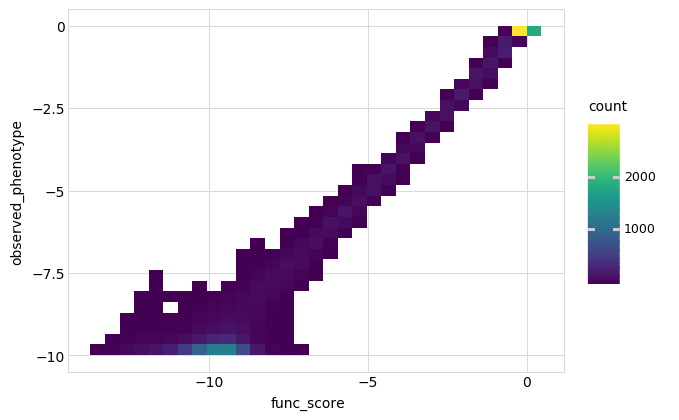

In [49]:
_ = (ggplot(variants_df, aes('func_score', 'observed_phenotype')) + 
     geom_bin2d()
     ).draw()

In [50]:
(variants_df
 [['func_score', 'latent_phenotype', 'observed_phenotype']]
 .corr()
 .round(2)
 )

,func_score,latent_phenotype,observed_phenotype
func_score,1.00,0.83,0.99
latent_phenotype,0.83,1.00,0.84
observed_phenotype,0.99,0.84,1.00
